Input is from other notebook.

In [ ]:
import os
import librosa
import pandas as pd
import numpy as np
import random
import keras
from scipy import signal
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tqdm._tqdm import trange
from keras.utils import np_utils

def readFromCsv(csvpth):
    # 生成数据列表
    # 读取wav文件函数
    #data = pd.read_csv('metadata/UrbanSound8K.csv')
    data = pd.read_csv(csvpth)
    valid_data = data[['slice_file_name', 'fold', 'classID', 'class']]
    valid_data['path'] = 'fold' + valid_data['fold'].astype('str') + '/' + valid_data['slice_file_name'].astype(
        'str')
    return valid_data


def splitData(current):
  
  D=[]
  csvPth = '/content/drive/MyDrive/Thesis_Keras/UrbanSound8K/metadata/UrbanSound8K.csv'
  #df=pd.read_csv(csvPth)
  #valid_data=readFromCsv(csvPth)
  i=1

  for row in tqdm(current.itertuples(),total=current.shape[0]):
        #print(row.path)
        #print(row.classID)
        #print(f"{i} out of {len(current)}")
        y1, sr1 = librosa.load("/content/drive/MyDrive/Thesis_Keras/UrbanSound8K/audio/" + row.path,sr=16000,duration=2)

        # print("y1shape=",y1.shape)
        if y1.shape != (32000,):
           continue

        
        mfccs = librosa.feature.mfcc(y=y1, sr=sr1, n_mfcc=40)
        i+=1
        D.append((mfccs, row.classID))
  dataset = D
  X,y=zip(*dataset)
  
  print("type of X is:",type(X))
  y=np.array(y).astype(np.int64)
  y = np.array(np_utils.to_categorical(y, 10))

  return  X,y


def save_npy(nparr,modelName,featureName,subDataset,fold):
    import os
    dirs = "drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy"+'/'+modelName+'/'+featureName+'/'+fold
    
    #Create a directory to place the dataset npy files.
    if not os.path.exists(dirs):
        os.makedirs(dirs)
        print(f"Created directory:{dirs}")
    
    subDataset+='.npy'
    print(subDataset)
    subsetPth=os.path.join(dirs,subDataset)
    #with open(subsetPth, 'w') as f:
    np.save(subsetPth, nparr)
    print(f"save {subDataset} done")
    print(f"Path:{subsetPth}")

In [ ]:
def Ten_fold():
    csvPth = '/content/drive/MyDrive/Thesis_Keras/UrbanSound8K/metadata/UrbanSound8K.csv'
    #df=pd.read_csv(csvPth)
    valid_data=readFromCsv(csvPth)
    #valid_data = df[['slice_file_name', 'fold', 'classID', 'class']][df['end'] - df['start']]
    # valid_data['path'] = 'fold' + valid_data['fold'].astype('str') + '/' + valid_data['slice_file_name'].astype(
    #     'str')
    for i in range(10):#Folder : "fold1" to "fold10"
        print(f"fold:{i+1} out of 10")
        current=valid_data[valid_data['fold'] == i+1]
        X,y = splitData(current)
        print("Dataset split done!")
        print("Saving subsets to .npy files!")
        
        save_npy(X, 'mfccConv2d', 'mfcc40x80', 'X',f"fold{i+1}")
        save_npy(y, 'mfccConv2d', 'mfcc40x80', 'y',f"fold{i+1}")

In [ ]:
Ten_fold()

10-fold


In [ ]:
from sklearn.metrics import accuracy_score
import tensorflow as tf
import numpy as np
from tqdm import tqdm
def generate_loader(i_val):
    train_X = []
    train_y=[]
    X_test=[]
    y_test=[]
    for i in range(10):
        if i + 1 == i_val:
            X_test = np.load(
                "drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy/mfccConv2d/mfcc40x80/"+f"fold{i + 1}"+"/X.npy"
                )
            y_test=np.load(
                "drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy/mfccConv2d/mfcc40x80/"+f"fold{i + 1}"+"/y.npy"
            )
        else:
            X_train = np.load(
                "drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy/mfccConv2d/mfcc40x80/"+f"fold{i + 1}"+"/X.npy"
            )
            y_train = np.load(
                "drive/MyDrive/Thesis_Keras/TenFoldDataset/datasetnpy/mfccConv2d/mfcc40x80/"+f"fold{i + 1}"+"/y.npy"
            )

            for item in X_train:
                train_X.append(item)
            for item in y_train:
                train_y.append(item)

    return np.array(train_X),np.array(train_y),np.array(X_test),np.array(y_test)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization, TimeDistributed,AveragePooling1D,AveragePooling2D,TimeDistributed,LeakyReLU,SpatialDropout2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

def build_model(input_length):
  model = Sequential()


  # Conv 1
  model.add(Conv2D(filters=32, 
          kernel_size=(3, 3), 
          kernel_regularizer=regularizers.L2(0.0005), 
          input_shape=(40,63,1)))
  model.add(LeakyReLU(alpha=0.1))
  model.add(BatchNormalization())

  model.add(SpatialDropout2D(0.07))
  model.add(Conv2D(filters=32, 
          kernel_size=(3, 3), 
           kernel_regularizer=regularizers.L2(0.0005)))
  model.add(LeakyReLU(alpha=0.1))
  model.add(BatchNormalization())


  # Max Pooling #1
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(SpatialDropout2D(0.07))
  model.add(Conv2D(filters=64, 
               kernel_size=(3, 3), 
               kernel_regularizer=regularizers.L2(0.0005)))
  model.add(LeakyReLU(alpha=0.1))
  model.add(BatchNormalization())

  model.add(SpatialDropout2D(0.14))
  model.add(Conv2D(filters=64, 
              kernel_size=(3,3), 
              kernel_regularizer=regularizers.L2(0.0005)))
  model.add(LeakyReLU(alpha=0.1))
  model.add(BatchNormalization())
    
   
  # Reduces each h×w feature map to a single number by taking the average of all h,w values.
  model.add(GlobalAveragePooling2D())


  # Softmax output
  model.add(Dense(10, activation='softmax'))
  return model

def train_model(model,X_train,Y_train,X_test,Y_test,foldNum):
  EPOCHS = 25
  # this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
  BATCH_SIZE = 64
  callbacks = []
  # model architecture
  
  # this controls the learning rate
  opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)
  #callbacks.append(BatchLoggerCallback(BATCH_SIZE, train_sample_count, epochs=EPOCHS))

  # train the neural network
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

  model.fit(X_train,Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=2,validation_split=0.1,shuffle=True)
  print(model.summary())
  # Use this flag to disable per-channel quantization for a model.
  # This can reduce RAM usage for convolutional models, but may have
  # an impact on accuracy.
  disable_per_channel_quantization = False
  print("Result of fold:"+f"{foldNum}")
  score = model.evaluate(
        x=X_test,
        y=Y_test)

##Preprocessing: MFCC

In [ ]:
for i in tqdm(range(10)):
  #from tensorflow.compat.v1.keras import backend as K
  import tensorflow as tf

  import os
  # os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
  # config = tf.compat.v1.ConfigProto()#对session进行参数配置
  # config.allow_soft_placement=True #如果你指定的设备不存在，允许TF自动分配设备
  # config.gpu_options.per_process_gpu_memory_fraction=0.7#分配百分之七十的显存给程序使用，避免内存溢出，可以自己调整
  # config.gpu_options.allow_growth = True#按需分配显存，这个比较重要
        
  # sess = tf.compat.v1.Session(config=config)
  # #tf.compat.v1.keras.backend.set_session(sess)
  # #K.set_session(sess)
  X_train,y_train,X_test,y_test = generate_loader(i+1)
  #print("inputdata",(X_train[1]))
  #print("rows",len(X_train[1]))
  #print("cols",len(X_train[1][1]))
  #print(y_train[1])
  input_len=len(X_train[0])
  model = build_model(input_len)
  if not i==0:
    model = build_model(input_len)
  
  train_model(model,X_train,y_train,X_test,y_test,i+1)
  model.save("/content/drive/MyDrive/Thesis_Keras/"+"model/saved/RajoCNN"+f"fold{i+1}"+".h5")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/25
99/99 - 13s - loss: 1.5348 - accuracy: 0.4776 - val_loss: 2.8344 - val_accuracy: 0.3123 - 13s/epoch - 127ms/step
Epoch 2/25
99/99 - 1s - loss: 1.2086 - accuracy: 0.6070 - val_loss: 1.4659 - val_accuracy: 0.4799 - 924ms/epoch - 9ms/step
Epoch 3/25
99/99 - 1s - loss: 1.1055 - accuracy: 0.6571 - val_loss: 1.3082 - val_accuracy: 0.5487 - 926ms/epoch - 9ms/step
Epoch 4/25
99/99 - 1s - loss: 1.0008 - accuracy: 0.6981 - val_loss: 1.2626 - val_accuracy: 0.6089 - 926ms/epoch - 9ms/step
Epoch 5/25
99/99 - 1s - loss: 0.9776 - accuracy: 0.7065 - val_loss: 1.1490 - val_accuracy: 0.6791 - 941ms/epoch - 10ms/step
Epoch 6/25
99/99 - 1s - loss: 0.9243 - accuracy: 0.7304 - val_loss: 1.2562 - val_accuracy: 0.6289 - 937ms/epoch - 9ms/step
Epoch 7/25
99/99 - 1s - loss: 0.9244 - accuracy: 0.7379 - val_loss: 1.4135 - val_accuracy: 0.5888 - 921ms/epoch - 9ms/step
Epoch 8/25
99/99 - 1s - loss: 0.9049 - accuracy: 0.7500 - val_loss: 1.4127 - val_accuracy: 0.6275 - 929ms/epoch - 9ms/step
Epoch 9/25
99/

 10%|█         | 1/10 [00:53<07:59, 53.29s/it]

Epoch 1/25
99/99 - 2s - loss: 1.5271 - accuracy: 0.4933 - val_loss: 3.0082 - val_accuracy: 0.3596 - 2s/epoch - 20ms/step
Epoch 2/25
99/99 - 1s - loss: 1.1871 - accuracy: 0.6295 - val_loss: 1.3473 - val_accuracy: 0.5745 - 923ms/epoch - 9ms/step
Epoch 3/25
99/99 - 1s - loss: 1.0974 - accuracy: 0.6679 - val_loss: 1.2822 - val_accuracy: 0.6060 - 926ms/epoch - 9ms/step
Epoch 4/25
99/99 - 1s - loss: 1.0378 - accuracy: 0.6931 - val_loss: 1.4015 - val_accuracy: 0.5845 - 924ms/epoch - 9ms/step
Epoch 5/25
99/99 - 1s - loss: 0.9611 - accuracy: 0.7309 - val_loss: 1.3730 - val_accuracy: 0.5874 - 925ms/epoch - 9ms/step
Epoch 6/25
99/99 - 1s - loss: 0.9337 - accuracy: 0.7280 - val_loss: 1.5213 - val_accuracy: 0.5573 - 928ms/epoch - 9ms/step
Epoch 7/25
99/99 - 1s - loss: 0.9104 - accuracy: 0.7463 - val_loss: 1.4085 - val_accuracy: 0.5659 - 918ms/epoch - 9ms/step
Epoch 8/25
99/99 - 1s - loss: 0.9125 - accuracy: 0.7516 - val_loss: 1.5388 - val_accuracy: 0.6189 - 931ms/epoch - 9ms/step
Epoch 9/25
99/99 -

 20%|██        | 2/10 [01:18<04:53, 36.68s/it]

Epoch 1/25
98/98 - 2s - loss: 1.5395 - accuracy: 0.4916 - val_loss: 2.7457 - val_accuracy: 0.2659 - 2s/epoch - 23ms/step
Epoch 2/25
98/98 - 1s - loss: 1.1831 - accuracy: 0.6223 - val_loss: 1.3785 - val_accuracy: 0.6040 - 925ms/epoch - 9ms/step
Epoch 3/25
98/98 - 1s - loss: 1.0568 - accuracy: 0.6788 - val_loss: 1.3388 - val_accuracy: 0.5954 - 925ms/epoch - 9ms/step
Epoch 4/25
98/98 - 1s - loss: 0.9955 - accuracy: 0.7093 - val_loss: 1.2846 - val_accuracy: 0.5954 - 919ms/epoch - 9ms/step
Epoch 5/25
98/98 - 1s - loss: 0.9327 - accuracy: 0.7325 - val_loss: 1.3414 - val_accuracy: 0.5491 - 929ms/epoch - 9ms/step
Epoch 6/25
98/98 - 1s - loss: 0.9173 - accuracy: 0.7408 - val_loss: 1.2888 - val_accuracy: 0.6171 - 915ms/epoch - 9ms/step
Epoch 7/25
98/98 - 1s - loss: 0.8516 - accuracy: 0.7677 - val_loss: 1.2365 - val_accuracy: 0.5809 - 933ms/epoch - 10ms/step
Epoch 8/25
98/98 - 1s - loss: 0.8389 - accuracy: 0.7714 - val_loss: 1.2586 - val_accuracy: 0.6199 - 936ms/epoch - 10ms/step
Epoch 9/25
98/98

 30%|███       | 3/10 [01:43<03:40, 31.50s/it]

Epoch 1/25
97/97 - 2s - loss: 1.5284 - accuracy: 0.5036 - val_loss: 3.2713 - val_accuracy: 0.2994 - 2s/epoch - 21ms/step
Epoch 2/25
97/97 - 1s - loss: 1.1649 - accuracy: 0.6294 - val_loss: 1.5627 - val_accuracy: 0.5451 - 905ms/epoch - 9ms/step
Epoch 3/25
97/97 - 1s - loss: 1.0608 - accuracy: 0.6758 - val_loss: 1.4737 - val_accuracy: 0.5843 - 919ms/epoch - 9ms/step
Epoch 4/25
97/97 - 1s - loss: 1.0059 - accuracy: 0.6966 - val_loss: 1.3775 - val_accuracy: 0.6206 - 909ms/epoch - 9ms/step
Epoch 5/25
97/97 - 1s - loss: 0.9508 - accuracy: 0.7202 - val_loss: 1.2535 - val_accuracy: 0.5770 - 911ms/epoch - 9ms/step
Epoch 6/25
97/97 - 1s - loss: 0.9041 - accuracy: 0.7468 - val_loss: 1.2690 - val_accuracy: 0.6090 - 910ms/epoch - 9ms/step
Epoch 7/25
97/97 - 1s - loss: 0.8816 - accuracy: 0.7523 - val_loss: 1.4483 - val_accuracy: 0.6105 - 923ms/epoch - 10ms/step
Epoch 8/25
97/97 - 1s - loss: 0.8586 - accuracy: 0.7653 - val_loss: 1.4376 - val_accuracy: 0.5669 - 913ms/epoch - 9ms/step
Epoch 9/25
97/97 

 40%|████      | 4/10 [02:08<02:53, 28.83s/it]

Epoch 1/25
98/98 - 2s - loss: 1.5753 - accuracy: 0.4749 - val_loss: 3.3678 - val_accuracy: 0.3108 - 2s/epoch - 21ms/step
Epoch 2/25
98/98 - 1s - loss: 1.2276 - accuracy: 0.6050 - val_loss: 1.4388 - val_accuracy: 0.5237 - 932ms/epoch - 10ms/step
Epoch 3/25
98/98 - 1s - loss: 1.0988 - accuracy: 0.6559 - val_loss: 1.5889 - val_accuracy: 0.4978 - 925ms/epoch - 9ms/step
Epoch 4/25
98/98 - 1s - loss: 1.0184 - accuracy: 0.6921 - val_loss: 1.5229 - val_accuracy: 0.6029 - 924ms/epoch - 9ms/step
Epoch 5/25
98/98 - 1s - loss: 0.9824 - accuracy: 0.7012 - val_loss: 1.5873 - val_accuracy: 0.5065 - 932ms/epoch - 10ms/step
Epoch 6/25
98/98 - 1s - loss: 0.9343 - accuracy: 0.7269 - val_loss: 1.2655 - val_accuracy: 0.6317 - 916ms/epoch - 9ms/step
Epoch 7/25
98/98 - 1s - loss: 0.9070 - accuracy: 0.7365 - val_loss: 1.2004 - val_accuracy: 0.6245 - 916ms/epoch - 9ms/step
Epoch 8/25
98/98 - 1s - loss: 0.8693 - accuracy: 0.7550 - val_loss: 1.2638 - val_accuracy: 0.6259 - 930ms/epoch - 9ms/step
Epoch 9/25
98/98

 50%|█████     | 5/10 [02:50<02:48, 33.77s/it]

Epoch 1/25
99/99 - 2s - loss: 1.5544 - accuracy: 0.4780 - val_loss: 2.5405 - val_accuracy: 0.3385 - 2s/epoch - 20ms/step
Epoch 2/25
99/99 - 1s - loss: 1.2001 - accuracy: 0.6118 - val_loss: 1.4655 - val_accuracy: 0.5306 - 939ms/epoch - 9ms/step
Epoch 3/25
99/99 - 1s - loss: 1.1024 - accuracy: 0.6513 - val_loss: 1.3998 - val_accuracy: 0.6046 - 934ms/epoch - 9ms/step
Epoch 4/25
99/99 - 1s - loss: 1.0166 - accuracy: 0.6932 - val_loss: 1.1397 - val_accuracy: 0.6543 - 929ms/epoch - 9ms/step
Epoch 5/25
99/99 - 1s - loss: 0.9504 - accuracy: 0.7199 - val_loss: 1.2004 - val_accuracy: 0.6558 - 930ms/epoch - 9ms/step
Epoch 6/25
99/99 - 1s - loss: 0.9474 - accuracy: 0.7283 - val_loss: 1.2646 - val_accuracy: 0.6316 - 936ms/epoch - 9ms/step
Epoch 7/25
99/99 - 1s - loss: 0.9133 - accuracy: 0.7413 - val_loss: 1.1881 - val_accuracy: 0.6501 - 941ms/epoch - 10ms/step
Epoch 8/25
99/99 - 1s - loss: 0.8627 - accuracy: 0.7669 - val_loss: 1.3029 - val_accuracy: 0.6174 - 933ms/epoch - 9ms/step
Epoch 9/25
99/99 

 60%|██████    | 6/10 [03:16<02:03, 30.91s/it]

Epoch 1/25
99/99 - 2s - loss: 1.6145 - accuracy: 0.4629 - val_loss: 1.8122 - val_accuracy: 0.4743 - 2s/epoch - 20ms/step
Epoch 2/25
99/99 - 1s - loss: 1.2443 - accuracy: 0.5982 - val_loss: 1.3332 - val_accuracy: 0.5629 - 926ms/epoch - 9ms/step
Epoch 3/25
99/99 - 1s - loss: 1.1072 - accuracy: 0.6571 - val_loss: 1.2953 - val_accuracy: 0.5614 - 920ms/epoch - 9ms/step
Epoch 4/25
99/99 - 1s - loss: 1.0295 - accuracy: 0.6945 - val_loss: 1.2568 - val_accuracy: 0.5914 - 934ms/epoch - 9ms/step
Epoch 5/25
99/99 - 1s - loss: 0.9774 - accuracy: 0.7080 - val_loss: 1.2606 - val_accuracy: 0.6443 - 932ms/epoch - 9ms/step
Epoch 6/25
99/99 - 1s - loss: 0.9593 - accuracy: 0.7239 - val_loss: 1.2435 - val_accuracy: 0.6286 - 924ms/epoch - 9ms/step
Epoch 7/25
99/99 - 1s - loss: 0.9247 - accuracy: 0.7377 - val_loss: 1.2612 - val_accuracy: 0.6471 - 928ms/epoch - 9ms/step
Epoch 8/25
99/99 - 1s - loss: 0.8854 - accuracy: 0.7504 - val_loss: 1.1701 - val_accuracy: 0.6214 - 927ms/epoch - 9ms/step
Epoch 9/25
99/99 -

 70%|███████   | 7/10 [03:41<01:27, 29.02s/it]

Epoch 1/25
99/99 - 2s - loss: 1.5637 - accuracy: 0.4827 - val_loss: 1.7803 - val_accuracy: 0.4872 - 2s/epoch - 20ms/step
Epoch 2/25
99/99 - 1s - loss: 1.1760 - accuracy: 0.6250 - val_loss: 1.3475 - val_accuracy: 0.5668 - 937ms/epoch - 9ms/step
Epoch 3/25
99/99 - 1s - loss: 1.0543 - accuracy: 0.6782 - val_loss: 1.3804 - val_accuracy: 0.5994 - 920ms/epoch - 9ms/step
Epoch 4/25
99/99 - 1s - loss: 0.9698 - accuracy: 0.7068 - val_loss: 1.3249 - val_accuracy: 0.5881 - 924ms/epoch - 9ms/step
Epoch 5/25
99/99 - 1s - loss: 0.9045 - accuracy: 0.7382 - val_loss: 1.3151 - val_accuracy: 0.5938 - 935ms/epoch - 9ms/step
Epoch 6/25
99/99 - 1s - loss: 0.9065 - accuracy: 0.7395 - val_loss: 1.5717 - val_accuracy: 0.5597 - 924ms/epoch - 9ms/step
Epoch 7/25
99/99 - 1s - loss: 0.8793 - accuracy: 0.7559 - val_loss: 1.4087 - val_accuracy: 0.5767 - 933ms/epoch - 9ms/step
Epoch 8/25
99/99 - 1s - loss: 0.8583 - accuracy: 0.7646 - val_loss: 1.3069 - val_accuracy: 0.6122 - 923ms/epoch - 9ms/step
Epoch 9/25
99/99 -

 80%|████████  | 8/10 [04:07<00:55, 27.93s/it]

Epoch 1/25
99/99 - 2s - loss: 1.5386 - accuracy: 0.4979 - val_loss: 1.8449 - val_accuracy: 0.4744 - 2s/epoch - 21ms/step
Epoch 2/25
99/99 - 1s - loss: 1.1894 - accuracy: 0.6300 - val_loss: 1.4092 - val_accuracy: 0.5926 - 929ms/epoch - 9ms/step
Epoch 3/25
99/99 - 1s - loss: 1.0715 - accuracy: 0.6765 - val_loss: 1.3226 - val_accuracy: 0.5769 - 938ms/epoch - 9ms/step
Epoch 4/25
99/99 - 1s - loss: 1.0086 - accuracy: 0.7005 - val_loss: 1.1953 - val_accuracy: 0.6339 - 933ms/epoch - 9ms/step
Epoch 5/25
99/99 - 1s - loss: 0.9407 - accuracy: 0.7268 - val_loss: 1.2994 - val_accuracy: 0.6040 - 929ms/epoch - 9ms/step
Epoch 6/25
99/99 - 1s - loss: 0.9404 - accuracy: 0.7301 - val_loss: 1.2358 - val_accuracy: 0.6439 - 928ms/epoch - 9ms/step
Epoch 7/25
99/99 - 1s - loss: 0.9166 - accuracy: 0.7481 - val_loss: 1.2013 - val_accuracy: 0.6239 - 926ms/epoch - 9ms/step
Epoch 8/25
99/99 - 1s - loss: 0.8881 - accuracy: 0.7569 - val_loss: 1.2948 - val_accuracy: 0.5897 - 943ms/epoch - 10ms/step
Epoch 9/25
99/99 

 90%|█████████ | 9/10 [04:32<00:27, 27.14s/it]

Epoch 1/25
99/99 - 2s - loss: 1.5720 - accuracy: 0.4851 - val_loss: 1.9886 - val_accuracy: 0.4251 - 2s/epoch - 20ms/step
Epoch 2/25
99/99 - 1s - loss: 1.2274 - accuracy: 0.6159 - val_loss: 1.8299 - val_accuracy: 0.4722 - 929ms/epoch - 9ms/step
Epoch 3/25
99/99 - 1s - loss: 1.0925 - accuracy: 0.6619 - val_loss: 1.5549 - val_accuracy: 0.5350 - 925ms/epoch - 9ms/step
Epoch 4/25
99/99 - 1s - loss: 1.0065 - accuracy: 0.6986 - val_loss: 1.7589 - val_accuracy: 0.4979 - 933ms/epoch - 9ms/step
Epoch 5/25
99/99 - 1s - loss: 0.9495 - accuracy: 0.7197 - val_loss: 1.4102 - val_accuracy: 0.5749 - 930ms/epoch - 9ms/step
Epoch 6/25
99/99 - 1s - loss: 0.9357 - accuracy: 0.7313 - val_loss: 1.3746 - val_accuracy: 0.6234 - 936ms/epoch - 9ms/step
Epoch 7/25
99/99 - 1s - loss: 0.9009 - accuracy: 0.7475 - val_loss: 1.3875 - val_accuracy: 0.5920 - 929ms/epoch - 9ms/step
Epoch 8/25
99/99 - 1s - loss: 0.8835 - accuracy: 0.7597 - val_loss: 1.3240 - val_accuracy: 0.6648 - 940ms/epoch - 9ms/step
Epoch 9/25
99/99 -

100%|██████████| 10/10 [04:57<00:00, 29.77s/it]


In [ ]:
# import pandas as pd
# import numpy as np

# pd.plotting.register_matplotlib_converters()
# import matplotlib.pyplot as plt
# %matplotlib inline
# import seaborn as sns

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report
# from sklearn.model_selection import GridSearchCV
# from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
# from tensorflow.keras.utils import to_categorical 
# import os,glob,skimage,librosa
# import librosa.display

# import warnings
# warnings.filterwarnings("ignore")    
# root="/content/drive/MyDrive/Thesis_Keras/"         #忽略警告信息
# csvPth = '/content/drive/MyDrive/Thesis_Keras/UrbanSound8K/metadata/UrbanSound8K.csv'
# examplePath = '/content/drive/MyDrive/Thesis_Keras/UrbanSound8K/audio/fold6/85249-2-0-79.wav'

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# df = pd.read_csv(csvPth)

# df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [ ]:
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#   print('Not using a high-RAM runtime')
# else:
#   print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:

# D=[]
# for i in range(8732):
#   try:
#     file_name = '/content/drive/MyDrive/Thesis_Keras/UrbanSound8K/audio/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
#     class_id = df["classID"][i]

#     X, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
#     print(f"{i}out of 8732")
#     if i == 4803 or i==6246:
#       continue
#     x = np.pad(X,(0,88200-X.shape[0]) if (0,88200-X.shape[0]>0) else (0,-88200+X.shape[0]),'constant')
#     print(f"{i}out of 8732")
#     mfccs = librosa.feature.mfcc(y=x, sr=sample_rate, n_mfcc=40)
#     print('shape: ',mfccs.shape)
#     feature = mfccs
#     label = class_id
#     D.append((feature,label)) 
#   except Exception:
#     print("Error encountered while parsing file: ", file_name)
#     mfccs,class_id = None, None
  


流式输出内容被截断，只能显示最后 5000 行内容。
7065out of 8732
shape:  (40, 173)
7066out of 8732
7066out of 8732
shape:  (40, 173)
7067out of 8732
7067out of 8732
shape:  (40, 173)
7068out of 8732
7068out of 8732
shape:  (40, 173)
7069out of 8732
7069out of 8732
shape:  (40, 173)
7070out of 8732
7070out of 8732
shape:  (40, 173)
7071out of 8732
7071out of 8732
shape:  (40, 173)
7072out of 8732
7072out of 8732
shape:  (40, 173)
7073out of 8732
7073out of 8732
shape:  (40, 173)
7074out of 8732
7074out of 8732
shape:  (40, 173)
7075out of 8732
7075out of 8732
shape:  (40, 173)
7076out of 8732
7076out of 8732
shape:  (40, 173)
7077out of 8732
7077out of 8732
shape:  (40, 173)
7078out of 8732
7078out of 8732
shape:  (40, 173)
7079out of 8732
7079out of 8732
shape:  (40, 173)
7080out of 8732
7080out of 8732
shape:  (40, 173)
7081out of 8732
7081out of 8732
shape:  (40, 173)
7082out of 8732
7082out of 8732
shape:  (40, 173)
7083out of 8732
7083out of 8732
shape:  (40, 173)
7084out of 8732
7084out of 8732
shape: 

In [ ]:
# X,Y=zip(*D)
# x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size = 0.2, random_state = 114514)


In [ ]:
# print(x_train[0])

[[-57.4849     -45.251606   -48.413826   ... -53.050816   -58.982986
  -63.604954  ]
 [ 68.89108     77.38608     86.85539    ...  83.0951      76.88148
   70.65805   ]
 [-37.255066   -39.359383   -49.60723    ... -50.950577   -51.041023
  -50.33483   ]
 ...
 [  0.12272656  -0.5983207    3.903356   ...   2.7751768    4.8916106
    2.592299  ]
 [ -4.1957498   -3.2601829   -5.1637363  ...  -1.213176    -0.69604737
   -2.4996417 ]
 [ -2.871941     1.0908763    5.690773   ...  -0.36992908   1.0608848
   -1.1971948 ]]


In [ ]:
# print(len(X))

8724


In [ ]:
# import pandas as pd
# import numpy as np

# def list_to_array (x):
#     dff = pd.concat([pd.DataFrame({'{}'.format(index):labels}) for index,labels in enumerate(x)],axis=1)
#     return dff.fillna(0).values.T.astype(int)

In [ ]:
# import tensorflow as tf

# X_train = np.array([x.reshape((40, 173, 1)) for x in x_train])
# X_test = np.array([x.reshape((40, 173, 1)) for x in x_test])


# Y_train = np.array(tf.keras.utils.to_categorical(y_train, 10))
# Y_test = np.array(tf.keras.utils.to_categorical(y_test, 10))


In [ ]:
# X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=1)

In [ ]:
# print(X_train[1145])

[[[-333.6221   ]
  [-311.13657  ]
  [-335.80563  ]
  ...
  [-136.9251   ]
  [-137.48051  ]
  [-135.16893  ]]

 [[ 112.64009  ]
  [ 123.88243  ]
  [ 111.9873   ]
  ...
  [ 175.55469  ]
  [ 174.30194  ]
  [ 135.70152  ]]

 [[ -22.691454 ]
  [ -18.922897 ]
  [  -8.819986 ]
  ...
  [-109.151215 ]
  [ -99.42627  ]
  [ -62.194763 ]]

 ...

 [[ -10.420927 ]
  [  -9.321856 ]
  [  -9.961016 ]
  ...
  [  11.713007 ]
  [  12.538005 ]
  [  11.297375 ]]

 [[   4.661276 ]
  [   7.484372 ]
  [   4.62512  ]
  ...
  [  25.790436 ]
  [  24.541182 ]
  [  24.393532 ]]

 [[   1.7712162]
  [  -2.81988  ]
  [  -2.8357847]
  ...
  [   4.8616576]
  [  16.61739  ]
  [  21.92479  ]]]


In [ ]:
# def save_npy(nparr,folder,featureName,subDataset):
#     import os
#     dirs = root+folder+"/data/datasetnpy"+'/'+featureName
    
#     #Create a directory to place the dataset npy files.
#     if not os.path.exists(dirs):
#         os.makedirs(dirs)
#         print(f"Created directory:{dirs}")
    
#     subDataset+='.npy'
#     print(subDataset)
#     subsetPth=os.path.join(dirs,subDataset)
#     #with open(subsetPth, 'w') as f:
#     np.save(subsetPth, nparr)
#     print(f"save {subDataset} done")
#     print(f"Path:{subsetPth}")

In [ ]:

# folderName="MFCC"

# save_npy(X_train, folderName, 'mfcc_40','x_train')
# save_npy(X_test, folderName, 'mfcc_40','x_test')
# save_npy(Y_train, folderName, 'mfcc_40','y_train')
# save_npy(Y_test, folderName, 'mfcc_40', 'y_test')

Created directory:/content/drive/MyDrive/Thesis_Keras/MFCC/data/datasetnpy/mfcc_40
x_train.npy
save x_train.npy done
Path:/content/drive/MyDrive/Thesis_Keras/MFCC/data/datasetnpy/mfcc_40/x_train.npy
x_test.npy
save x_test.npy done
Path:/content/drive/MyDrive/Thesis_Keras/MFCC/data/datasetnpy/mfcc_40/x_test.npy
y_train.npy
save y_train.npy done
Path:/content/drive/MyDrive/Thesis_Keras/MFCC/data/datasetnpy/mfcc_40/y_train.npy
y_test.npy
save y_test.npy done
Path:/content/drive/MyDrive/Thesis_Keras/MFCC/data/datasetnpy/mfcc_40/y_test.npy


In [ ]:
# import pandas as pd
# import numpy as np

# pd.plotting.register_matplotlib_converters()
# import matplotlib.pyplot as plt
# %matplotlib inline
# import seaborn as sns

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report
# from sklearn.model_selection import GridSearchCV
# from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
# from tensorflow.keras.utils import to_categorical 
# import os,glob,skimage,librosa
# import librosa.display

# import warnings
# warnings.filterwarnings("ignore")  

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# X = np.load('/content/drive/MyDrive/Thesis_Keras/MFCC/data/datasetnpy/mfcc_40/x_train.npy',allow_pickle=True)
# Y = np.load('/content/drive/MyDrive/Thesis_Keras/MFCC/data/datasetnpy/mfcc_40/y_train.npy')

# X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=1)


In [ ]:
# X_test=np.load('/content/drive/MyDrive/Thesis_Keras/MFCC/data/datasetnpy/mfcc_40/x_test.npy',allow_pickle=True)
# Y_test = np.load('/content/drive/MyDrive/Thesis_Keras/MFCC/data/datasetnpy/mfcc_40/y_test.npy')

In [ ]:
# print(X_train.shape)
# print(X_train.shape[1])
# print(X_train.shape[2])

(4466, 40, 173, 1)
40
173


This part no longer used. 

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization, TimeDistributed,LeakyReLU,SpatialDropout2D,GlobalAveragePooling2D
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras import regularizers
# EPOCHS = 100
# # this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
# BATCH_SIZE = 32
# input_length=len(X_train[0])
# callbacks = []

In [ ]:
    
# def build_model(bands,frames,channels,spatial_dropout_rate_1,spatial_dropout_rate_2,l2_rate):



#     model = Sequential()


#     # Conv 1
#     model.add(Conv2D(filters=32, 
#                      kernel_size=(3, 3), 
#                      kernel_regularizer=regularizers.L2(l2_rate), 
#                      input_shape=(bands,frames,channels)))
#     model.add(LeakyReLU(alpha=0.1))
#     model.add(BatchNormalization())

#     model.add(SpatialDropout2D(spatial_dropout_rate_1))
#     model.add(Conv2D(filters=32, 
#                      kernel_size=(3, 3), 
#                      kernel_regularizer=regularizers.L2(l2_rate)))
#     model.add(LeakyReLU(alpha=0.1))
#     model.add(BatchNormalization())


#     # Max Pooling #1
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     model.add(SpatialDropout2D(spatial_dropout_rate_1))
#     model.add(Conv2D(filters=64, 
#                      kernel_size=(3, 3), 
#                      kernel_regularizer=regularizers.L2(l2_rate)))
#     model.add(LeakyReLU(alpha=0.1))
#     model.add(BatchNormalization())

#     model.add(SpatialDropout2D(spatial_dropout_rate_2))
#     model.add(Conv2D(filters=64, 
#                      kernel_size=(3,3), 
#                      kernel_regularizer=regularizers.L2(l2_rate)))
#     model.add(LeakyReLU(alpha=0.1))
#     model.add(BatchNormalization())
    
   
#     # Reduces each h×w feature map to a single number by taking the average of all h,w values.
#     model.add(GlobalAveragePooling2D())


#     # Softmax output
#     model.add(Dense(10, activation='softmax'))


#     return model

In [ ]:
# spatial_dropout_rate_1 = 0.07
# spatial_dropout_rate_2 = 0.14
# l2_rate = 0.0005
# model=build_model(X_train.shape[1],X_train.shape[2],1,spatial_dropout_rate_1,spatial_dropout_rate_2,l2_rate)
# print(model.summary())
# # train the neural network
# opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)
# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# model.fit(X_train,Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val,Y_val), verbose=2, callbacks=callbacks)

# # Use this flag to disable per-channel quantization for a model.
# # This can reduce RAM usage for convolutional models, but may have
# # an impact on accuracy.
# disable_per_channel_quantization = False

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 38, 171, 32)       320       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 38, 171, 32)       0         
                                                                 
 batch_normalization_9 (Batc  (None, 38, 171, 32)      128       
 hNormalization)                                                 
                                                                 
 spatial_dropout2d_6 (Spatia  (None, 38, 171, 32)      0         
 lDropout2D)                                                     
                                                                 
 conv2d_11 (Conv2D)          (None, 36, 169, 32)       9248      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 36, 169, 32)      

In [ ]:
# Save the model to disk
# model.save('/content/drive/MyDrive/Thesis_Keras/MFCC/data/saved_models/mfcc_RajoCNN')

In [ ]:
# score = model.evaluate(
#         x=X_test,
#         y=Y_test)

55/55 [==============================] - 0s 6ms/step - loss: 0.7704 - accuracy: 0.8327


模型名称： MFCC+RajoCNN

准确度：0.8327

In [ ]:
# from sklearn.metrics import confusion_matrix, precision_recall_curve
# from sklearn.metrics import roc_curve, auc
# import itertools
# def plot_confusion_matrix(cm,
#                           target_names,
#                           title='Confusion matrix, Model:MFCC+Conv2D',
#                           cmap='Blues',#这个地方设置混淆矩阵的颜色主题，这个主题看着就干净~
#                           normalize=True):
   
 
#     accuracy = np.trace(cm) / float(np.sum(cm))
#     misclass = 1 - accuracy
    
#     if cmap is None:
#         cmap = plt.get_cmap('Blues')
        
#     plt.figure(figsize=(9, 7))
# #    plt.figure()
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()

#     if target_names is not None:
#         tick_marks = np.arange(len(target_names))
#         plt.xticks(tick_marks, target_names, rotation=45)
#         plt.yticks(tick_marks, target_names)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


#     thresh = cm.max() / 1.5 if normalize else cm.max() / 2
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         if normalize:
#             plt.text(j, i, "{:0.4f}".format(cm[i, j]),
#                      horizontalalignment="center",
#                      color="white" if cm[i, j] > thresh else "black")
#         else:
#             plt.text(j, i, "{:,}".format(cm[i, j]),
#                      horizontalalignment="center",
#                      color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label',size=15)
#     plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass),size=15)
#     plt.savefig('/content/drive/MyDrive/Thesis_Keras/MFCC/data/results/mfcc40_conv2/Confusion_Matrix.svg', format='svg',bbox_inches = 'tight')
#     plt.savefig('/content/drive/MyDrive/Thesis_Keras/MFCC/data/results/mfcc40_conv2/Confusion_Matrix.png', format='png',bbox_inches = 'tight')
#     plt.show()

# # 显示混淆矩阵
# def props_to_onehot(props):
#     if isinstance(props, list):
#         props = np.array(props)
#     a = np.argmax(props, axis=1)
#     b = np.zeros((len(a), props.shape[1]))
#     b[np.arange(len(a)), a] = 1
#     return b



# def plot_confuse(model, x_val, y_val):
#     predictions = props_to_onehot(model.predict(x_val)).argmax(axis=-1)
    
#     truelabel = y_val.argmax(axis=-1)   # 将one-hot转化为label
#     conf_mat = confusion_matrix(y_true=truelabel, y_pred=predictions)
#     plt.figure()
#     plot_confusion_matrix(conf_mat, range(np.max(truelabel)+1))


<Figure size 432x288 with 0 Axes>

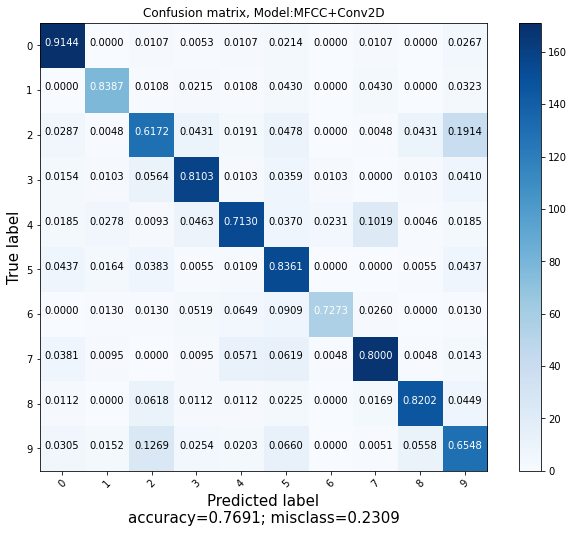

In [ ]:
# plot_confuse(model, X_test, Y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:255: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  "Numerical issues were encountered "


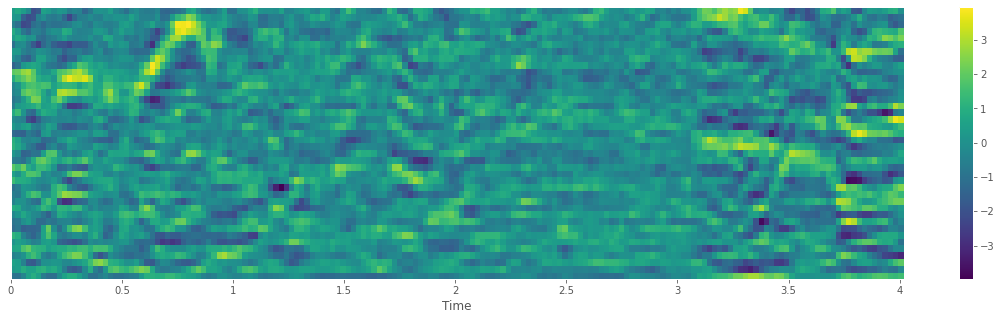

[1.0000001  1.0000001  1.         1.         1.0000001  1.0000001
 1.         0.99999994 1.0000001  1.         0.9999998  1.
 1.         0.99999994 1.         1.         0.99999994 1.
 1.         1.0000001  1.0000001  0.99999994 0.99999994 1.
 1.0000001  1.0000001  1.0000001  1.0000001  1.         1.0000001
 1.0000001  1.         1.         0.9999998  0.99999994 0.9999998
 1.         1.         1.         0.99999994]
[-1.1025136e-08  0.0000000e+00  6.8907102e-09  2.7562841e-09
  0.0000000e+00  2.2050273e-08  5.5125682e-09  1.1025136e-08
 -4.1344261e-09  5.5125682e-09 -1.3781420e-09  0.0000000e+00
 -1.1025136e-08  1.1025136e-08 -1.1025136e-08 -2.2050273e-08
 -5.5125682e-09 -2.7562841e-09  1.1025136e-08  1.1025136e-08
  0.0000000e+00 -5.5125682e-09 -5.5125682e-09  0.0000000e+00
 -1.1025136e-08 -1.1025136e-08  0.0000000e+00 -2.2050273e-08
  0.0000000e+00  0.0000000e+00  0.0000000e+00 -5.5125682e-09
 -4.1344261e-09  1.1025136e-08 -5.5125682e-09 -5.5125682e-09
  7.5797812e-09 -8.2688523e-09

In [ ]:
# mfccs = extract_feature(examplePath)
# plt.figure(figsize=(20,5))
# librosa.display.specshow(mfccs, sr=22050, x_axis='time', cmap='viridis')
# plt.colorbar()
# plt.show()
# print (mfccs.var(axis=1))
# print (mfccs.mean(axis=1))
